# Heart Attack Risk Prediction - Classification Model

## Task 01: Machine Learning Classification for Heart Attack Risk Prediction

### Problem Overview
This notebook implements a comprehensive machine learning solution to predict heart attack risk based on patient demographics, lifestyle factors, medical history, and clinical measurements. The model is built using data from the Global Heart Health Study conducted by an international medical consortium in 2025.

### Dataset Features
- **Demographics**: Age, Sex, Country, Continent, Hemisphere, Income
- **Lifestyle**: Smoking, Alcohol, Diet, Exercise Hours, Physical Activity, Sedentary Hours, Sleep Hours
- **Medical History**: Diabetes, Obesity, Family History, Previous Heart Problems, Medication Use
- **Clinical Tests**: Cholesterol, Triglycerides, BMI, Stress Level, Heart Rate, Blood Pressure

### Evaluation Metrics
The model will be evaluated using:
- Accuracy
- Precision, Recall, F1-score
- ROC-AUC Score
- **Primary Metric**: Recall (for competition scoring)

## 1. Import Required Libraries and Load Data

In [1]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, roc_curve)
import xgboost as xgb

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load datasets from Google Drive
# Note: You need to download the datasets from the provided URLs and place them in the same directory
# Train Dataset URL: https://drive.google.com/file/d/1OQWfTaTaRatB8gT3sg723LRtYYKBm5tU/view?usp=sharing
# Test Dataset URL: https://drive.google.com/file/d/1MznJKj9_X4TBgnkbMWfBSBv9jyCQ6krd/view?usp=sharing

# Load the uploaded datasets
print("📂 Loading uploaded datasets...")

try:
    # Try common CSV file names for the datasets
    possible_train_names = ['train_heart_attack.csv', 'train.csv', 'training_data.csv', 'heart_attack_train.csv']
    possible_test_names = ['test_heart_attack.csv', 'test.csv', 'test_data.csv', 'heart_attack_test.csv']
    
    train_df = None
    test_df = None
    
    # Try to find and load training dataset
    for train_name in possible_train_names:
        try:
            train_df = pd.read_csv(train_name)
            print(f"✅ Training dataset loaded from: {train_name}")
            break
        except FileNotFoundError:
            continue
    
    # Try to find and load test dataset
    for test_name in possible_test_names:
        try:
            test_df = pd.read_csv(test_name)
            print(f"✅ Test dataset loaded from: {test_name}")
            break
        except FileNotFoundError:
            continue
    
    if train_df is None or test_df is None:
        raise FileNotFoundError("Datasets not found with expected names")
    
    print(f"📊 Training dataset shape: {train_df.shape}")
    print(f"📊 Test dataset shape: {test_df.shape}")
    
    # Verify dataset structure
    print(f"\n📋 Training dataset columns: {len(train_df.columns)}")
    print(f"📋 Test dataset columns: {len(test_df.columns)}")
    
    if 'heart_attack_risk' in train_df.columns:
        print("✅ Target variable 'heart_attack_risk' found in training data")
    else:
        print("⚠️  Target variable 'heart_attack_risk' not found - please check column names")
        
except FileNotFoundError:
    print("❌ Could not find the dataset files!")
    print("Please make sure you have uploaded the datasets with one of these names:")
    print("Training data: train_heart_attack.csv, train.csv, training_data.csv, or heart_attack_train.csv")
    print("Test data: test_heart_attack.csv, test.csv, test_data.csv, or heart_attack_test.csv")
    print("\nFiles should be in the same directory as this notebook.")
    raise

📂 Loading uploaded datasets...
✅ Training dataset loaded from: train.csv
✅ Test dataset loaded from: test.csv
📊 Training dataset shape: (7963, 26)
📊 Test dataset shape: (800, 25)

📋 Training dataset columns: 26
📋 Test dataset columns: 25
✅ Target variable 'heart_attack_risk' found in training data


## 2. Data Exploration and Understanding

In [3]:
# Basic information about the datasets
print("=" * 60)
print("TRAINING DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)}")
print("\nData Types:")
print(train_df.dtypes)
print("\n" + "=" * 60)
print("TEST DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {test_df.shape}")
print(f"Missing 'heart_attack_risk' column: {'heart_attack_risk' not in test_df.columns}")

TRAINING DATASET OVERVIEW
Shape: (7963, 26)
Columns: ['patient_id', 'age', 'sex', 'chol', 'bp', 'hr', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'exercise_hr_wk', 'diet', 'prev_heart_prob', 'med_use', 'stress_lvl', 'sedentary_hr', 'income', 'bmi', 'triglycerides', 'phys_act_days', 'sleep_hr', 'country', 'continent', 'hemisphere', 'heart_attack_risk']

Data Types:
patient_id            object
age                    int64
sex                   object
chol                   int64
bp                    object
hr                     int64
diabetes               int64
family_history         int64
smoking                int64
obesity                int64
alcohol                int64
exercise_hr_wk       float64
diet                  object
prev_heart_prob        int64
med_use                int64
stress_lvl             int64
sedentary_hr         float64
income                 int64
bmi                  float64
triglycerides          int64
phys_act_days          int64
sleep

In [4]:
# Display first few rows
print("First 5 rows of training data:")
display(train_df.head())

print("\nFirst 5 rows of test data:")
display(test_df.head())

First 5 rows of training data:


,patient_id,age,sex,chol,bp,hr,diabetes,family_history,smoking,obesity,alcohol,exercise_hr_wk,diet,prev_heart_prob,med_use,stress_lvl,sedentary_hr,income,bmi,triglycerides,phys_act_days,sleep_hr,country,continent,hemisphere,heart_attack_risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0



First 5 rows of test data:


,patient_id,age,sex,chol,bp,hr,diabetes,family_history,smoking,obesity,alcohol,exercise_hr_wk,diet,prev_heart_prob,med_use,stress_lvl,sedentary_hr,income,bmi,triglycerides,phys_act_days,sleep_hr,country,continent,hemisphere
0,VRK5064,36,Male,164,118/103,46,1,1,1,0,0,4.351139,Healthy,0,0,3,5.808121,291026,32.636491,320,3,4,South Korea,Asia,Northern Hemisphere
1,NEN2365,66,Male,355,158/89,49,0,0,1,1,0,8.530776,Unhealthy,1,1,9,3.108304,96002,26.396081,709,0,7,United Kingdom,Europe,Northern Hemisphere
2,KXT2493,59,Female,370,172/81,104,0,0,1,0,0,3.780670,Unhealthy,1,0,6,8.220722,277303,18.920591,53,4,5,United States,North America,Northern Hemisphere
3,TKO0406,88,Male,296,178/67,53,1,0,1,1,0,0.870540,Unhealthy,0,0,6,5.974984,122979,25.688879,86,1,10,New Zealand,Australia,Southern Hemisphere
4,GDP2405,74,Male,294,130/67,105,1,1,1,0,0,8.864218,Unhealthy,0,0,1,10.180945,118594,39.937584,138,7,9,Japan,Asia,Northern Hemisphere


In [5]:
# Statistical summary of numerical features
print("Statistical Summary of Numerical Features:")
display(train_df.describe())

# Missing values analysis
print("\nMissing Values Analysis:")
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

missing_df = pd.DataFrame({
    'Training Set': missing_train,
    'Test Set': missing_test
})
missing_df = missing_df[missing_df.sum(axis=1) > 0]
if len(missing_df) > 0:
    display(missing_df)
else:
    print("✅ No missing values found in either dataset!")

Statistical Summary of Numerical Features:


,age,chol,hr,diabetes,family_history,smoking,obesity,alcohol,exercise_hr_wk,prev_heart_prob,med_use,stress_lvl,sedentary_hr,income,bmi,triglycerides,phys_act_days,sleep_hr,heart_attack_risk
count,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000
mean,53.685922,259.574658,75.102474,0.653020,0.489640,0.896521,0.504207,0.597890,9.999996,0.495165,0.498179,5.472812,5.976430,158283.114279,28.891190,418.370715,3.486877,7.022353,0.343966
std,21.237794,80.824235,20.583831,0.476039,0.499924,0.304602,0.500014,0.490355,5.778830,0.500008,0.500028,2.858878,3.465806,80715.248604,6.318153,223.794036,2.278560,1.987275,0.475060
min,18.000000,120.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002442,0.000000,0.000000,1.000000,0.001263,20062.000000,18.002337,30.000000,0.000000,4.000000,0.000000
25%,35.000000,191.000000,57.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.979003,0.000000,0.000000,3.000000,2.978895,87835.000000,23.420212,227.500000,2.000000,5.000000,0.000000
50%,54.000000,259.000000,75.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.062622,0.000000,0.000000,5.000000,5.904138,157830.000000,28.779074,419.000000,3.000000,7.000000,0.000000
75%,72.000000,329.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.038864,1.000000,1.000000,8.000000,8.995663,228486.500000,34.320578,614.000000,5.000000,9.000000,1.000000
max,90.000000,400.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.998709,1.000000,1.000000,10.000000,11.999313,299954.000000,39.997211,800.000000,7.000000,10.000000,1.000000



Missing Values Analysis:
✅ No missing values found in either dataset!


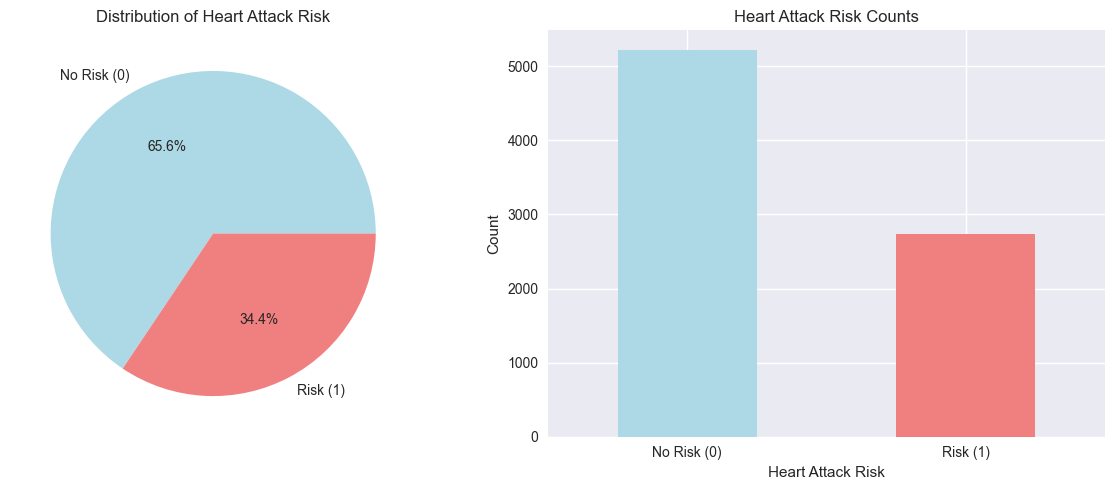

Target variable distribution:
No Risk (0): 5224 (65.6%)
Risk (1): 2739 (34.4%)


In [6]:
# Target variable distribution
plt.figure(figsize=(12, 5))

# Target distribution
plt.subplot(1, 2, 1)
target_counts = train_df['heart_attack_risk'].value_counts()
plt.pie(target_counts.values, labels=['No Risk (0)', 'Risk (1)'], autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Heart Attack Risk')

# Target distribution bar plot
plt.subplot(1, 2, 2)
target_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Heart Attack Risk Counts')
plt.xlabel('Heart Attack Risk')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Risk (0)', 'Risk (1)'], rotation=0)

plt.tight_layout()
plt.show()

print(f"Target variable distribution:")
print(f"No Risk (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"Risk (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.1f}%)")

In [7]:
# Categorical variables analysis
categorical_cols = ['sex', 'diet', 'country', 'continent', 'hemisphere']
binary_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'prev_heart_prob', 'med_use']

print("Unique values in categorical columns:")
for col in categorical_cols:
    if col in train_df.columns:
        print(f"{col}: {train_df[col].unique()}")

print("\nBinary variable distributions:")
for col in binary_cols:
    if col in train_df.columns:
        counts = train_df[col].value_counts()
        print(f"{col}: {dict(counts)}")

Unique values in categorical columns:
sex: ['Male' 'Female']
diet: ['Average' 'Unhealthy' 'Healthy']
country: ['Argentina' 'Canada' 'France' 'Thailand' 'Japan' 'Brazil' 'South Africa'
 'Vietnam' 'China' 'Italy' 'United States' 'Spain' 'India' 'Nigeria'
 'New Zealand' 'South Korea' 'Germany' 'Australia' 'Colombia'
 'United Kingdom']
continent: ['South America' 'North America' 'Europe' 'Asia' 'Africa' 'Australia']
hemisphere: ['Southern Hemisphere' 'Northern Hemisphere']

Binary variable distributions:
diabetes: {1: np.int64(5200), 0: np.int64(2763)}
family_history: {0: np.int64(4064), 1: np.int64(3899)}
smoking: {1: np.int64(7139), 0: np.int64(824)}
obesity: {1: np.int64(4015), 0: np.int64(3948)}
alcohol: {1: np.int64(4761), 0: np.int64(3202)}
prev_heart_prob: {0: np.int64(4020), 1: np.int64(3943)}
med_use: {0: np.int64(3996), 1: np.int64(3967)}


## 3. Data Preprocessing and Cleaning

In [8]:
# Create copies of datasets for preprocessing
train_processed = train_df.copy()
test_processed = test_df.copy()

# Function to parse blood pressure
def parse_blood_pressure(bp_str):
    """Parse blood pressure string format 'systolic/diastolic' into separate values"""
    try:
        systolic, diastolic = bp_str.split('/')
        return int(systolic), int(diastolic)
    except:
        return np.nan, np.nan

# Parse blood pressure for both datasets
print("Parsing blood pressure values...")
bp_train = train_processed['bp'].apply(parse_blood_pressure)
bp_test = test_processed['bp'].apply(parse_blood_pressure)

train_processed['systolic_bp'] = [bp[0] for bp in bp_train]
train_processed['diastolic_bp'] = [bp[1] for bp in bp_train]

test_processed['systolic_bp'] = [bp[0] for bp in bp_test]
test_processed['diastolic_bp'] = [bp[1] for bp in bp_test]

# Drop original bp column
train_processed = train_processed.drop('bp', axis=1)
test_processed = test_processed.drop('bp', axis=1)

print("✅ Blood pressure parsed into systolic and diastolic components")

Parsing blood pressure values...
✅ Blood pressure parsed into systolic and diastolic components


In [9]:
# Encode categorical variables
print("Encoding categorical variables...")

# Binary encoding for sex (Male=1, Female=0)
train_processed['sex'] = train_processed['sex'].map({'Male': 1, 'Female': 0})
test_processed['sex'] = test_processed['sex'].map({'Male': 1, 'Female': 0})

# Ordinal encoding for diet (Poor=0, Average=1, Healthy=2)
diet_mapping = {'Poor': 0, 'Average': 1, 'Healthy': 2}
train_processed['diet'] = train_processed['diet'].map(diet_mapping)
test_processed['diet'] = test_processed['diet'].map(diet_mapping)

# One-hot encoding for country, continent, hemisphere
categorical_features = ['country', 'continent', 'hemisphere']

for feature in categorical_features:
    # Get unique values from training set
    unique_values = train_processed[feature].unique()
    
    # Create dummy variables
    train_dummies = pd.get_dummies(train_processed[feature], prefix=feature, drop_first=True)
    test_dummies = pd.get_dummies(test_processed[feature], prefix=feature, drop_first=True)
    
    # Ensure test set has same columns as training set
    for col in train_dummies.columns:
        if col not in test_dummies.columns:
            test_dummies[col] = 0
    
    # Add dummy variables to datasets
    train_processed = pd.concat([train_processed, train_dummies], axis=1)
    test_processed = pd.concat([test_processed, test_dummies[train_dummies.columns]], axis=1)
    
    # Drop original categorical column
    train_processed = train_processed.drop(feature, axis=1)
    test_processed = test_processed.drop(feature, axis=1)

print("✅ Categorical variables encoded successfully")
print(f"Training set shape after encoding: {train_processed.shape}")
print(f"Test set shape after encoding: {test_processed.shape}")

Encoding categorical variables...
✅ Categorical variables encoded successfully
Training set shape after encoding: (7963, 49)
Test set shape after encoding: (800, 48)


## 4. Feature Engineering and Selection

In [10]:
# Create additional features
print("Creating additional features...")

# Pulse pressure (difference between systolic and diastolic BP)
train_processed['pulse_pressure'] = train_processed['systolic_bp'] - train_processed['diastolic_bp']
test_processed['pulse_pressure'] = test_processed['systolic_bp'] - test_processed['diastolic_bp']

# Age groups
train_processed['age_group'] = pd.cut(train_processed['age'], 
                                    bins=[0, 30, 45, 60, 100], 
                                    labels=[0, 1, 2, 3])
test_processed['age_group'] = pd.cut(test_processed['age'], 
                                   bins=[0, 30, 45, 60, 100], 
                                   labels=[0, 1, 2, 3])

# BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

train_processed['bmi_category'] = train_processed['bmi'].apply(categorize_bmi)
test_processed['bmi_category'] = test_processed['bmi'].apply(categorize_bmi)

# Exercise ratio (exercise hours vs sedentary hours)
train_processed['exercise_sedentary_ratio'] = train_processed['exercise_hr_wk'] / (train_processed['sedentary_hr'] + 1)
test_processed['exercise_sedentary_ratio'] = test_processed['exercise_hr_wk'] / (test_processed['sedentary_hr'] + 1)

print("✅ Additional features created:")
print("- Pulse pressure")
print("- Age groups")  
print("- BMI categories")
print("- Exercise to sedentary ratio")

Creating additional features...
✅ Additional features created:
- Pulse pressure
- Age groups
- BMI categories
- Exercise to sedentary ratio


In [11]:
# Prepare features and target
# Separate features and target
X = train_processed.drop(['patient_id', 'heart_attack_risk'], axis=1)
y = train_processed['heart_attack_risk']
X_test = test_processed.drop(['patient_id'], axis=1)

# Ensure test set has same features as training set
missing_features = set(X.columns) - set(X_test.columns)
extra_features = set(X_test.columns) - set(X.columns)

if missing_features:
    print(f"Adding missing features to test set: {missing_features}")
    for feature in missing_features:
        X_test[feature] = 0

if extra_features:
    print(f"Removing extra features from test set: {extra_features}")
    X_test = X_test.drop(extra_features, axis=1)

# Reorder columns to match training set
X_test = X_test[X.columns]

print(f"Final feature set shape: {X.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Final feature set shape: (7963, 51)
Test set shape: (800, 51)
Target distribution: {0: 5224, 1: 2739}


Top 15 features correlated with Heart Attack Risk:
country_United States       0.025166
pulse_pressure              0.023840
country_Italy               0.022187
systolic_bp                 0.020591
continent_North America     0.020069
country_India               0.019479
country_Nigeria             0.018244
alcohol                     0.017049
country_South Korea         0.017037
sleep_hr                    0.016793
diet                        0.016114
triglycerides               0.016049
exercise_sedentary_ratio    0.015998
continent_Europe            0.015729
income                      0.015674
dtype: float64


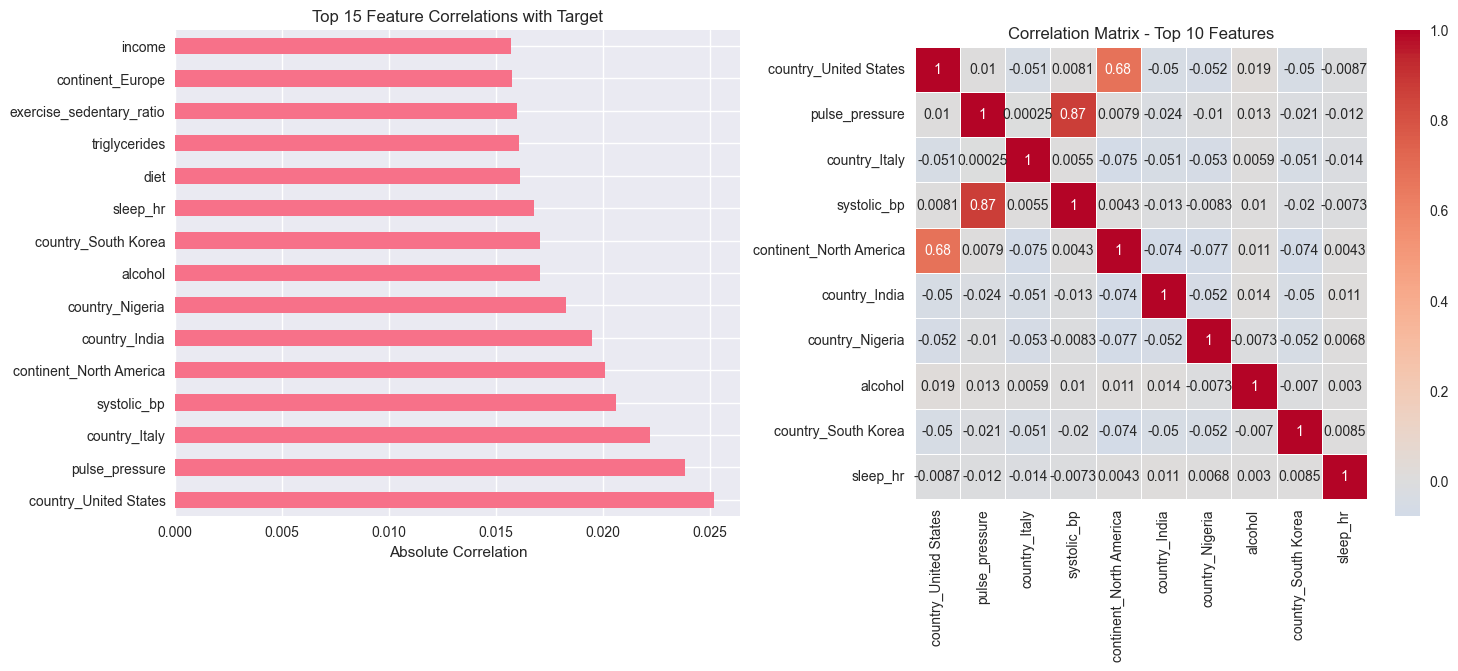

In [12]:
# Feature correlation analysis
plt.figure(figsize=(15, 12))

# Calculate correlation with target variable
feature_correlations = X.corrwith(y).abs().sort_values(ascending=False)

# Display top 15 features correlated with target
print("Top 15 features correlated with Heart Attack Risk:")
print(feature_correlations.head(15))

# Visualize feature correlations
plt.subplot(2, 2, 1)
feature_correlations.head(15).plot(kind='barh')
plt.title('Top 15 Feature Correlations with Target')
plt.xlabel('Absolute Correlation')

# Correlation heatmap of top features
plt.subplot(2, 2, 2)
top_features = feature_correlations.head(10).index.tolist()
correlation_matrix = X[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, linewidths=0.5)
plt.title('Correlation Matrix - Top 10 Features')

plt.tight_layout()
plt.show()

In [18]:
# Check for NaN values and fix data issues
print("Checking for NaN values...")
print(f"X NaN count: {X.isnull().sum().sum()}")
print(f"X_test NaN count: {X_test.isnull().sum().sum()}")

# Fill NaN values based on data type
for col in X.columns:
    if X[col].dtype == 'object' or str(X[col].dtype) == 'category':
        # For categorical/object columns, fill with mode (most frequent)
        mode_val = X[col].mode()[0] if not X[col].mode().empty else 0
        X[col] = X[col].fillna(mode_val)
        if col in X_test.columns:
            X_test[col] = X_test[col].fillna(mode_val)
    else:
        # For numerical columns, fill with mean
        mean_val = X[col].mean()
        X[col] = X[col].fillna(mean_val)
        if col in X_test.columns:
            X_test[col] = X_test[col].fillna(mean_val)

print(f"After filling - X NaN count: {X.isnull().sum().sum()}")
print(f"After filling - X_test NaN count: {X_test.isnull().sum().sum()}")

# Verify data shapes
print(f"Final X shape: {X.shape}")
print(f"Final X_test shape: {X_test.shape}")
print(f"Target shape: {y.shape}")
print("✅ Data cleaning complete")

Checking for NaN values...
X NaN count: 2617
X_test NaN count: 274
After filling - X NaN count: 0
After filling - X_test NaN count: 0
Final X shape: (7963, 51)
Final X_test shape: (800, 51)
Target shape: (7963,)
✅ Data cleaning complete


In [21]:
# Convert all categorical columns to numerical for XGBoost compatibility
from sklearn.preprocessing import LabelEncoder

print("Converting categorical features to numerical...")

# Create label encoders for categorical columns
label_encoders = {}
categorical_columns = X.select_dtypes(include=['category', 'object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    # Apply same transformation to test set
    if col in X_test.columns:
        X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print(f"Converted {len(categorical_columns)} categorical columns: {list(categorical_columns)}")
print(f"Final X dtypes: {X.dtypes.value_counts()}")
print("✅ Categorical conversion complete")

Converting categorical features to numerical...
Converted 1 categorical columns: ['age_group']
Final X dtypes: bool       25
int64      21
float64     5
Name: count, dtype: int64
✅ Categorical conversion complete


## 5. Model Training and Comparison

In [22]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}")

# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print("✅ Data split and models defined")

Training set: (6370, 51), (6370,)
Validation set: (1593, 51), (1593,)
Test set: (800, 51)
✅ Data split and models defined


In [23]:
# Train and evaluate models
results = {}
cv_scores = {}

print("Training and evaluating models...")
print("=" * 60)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Use scaled data for models that benefit from scaling
    if name in ['Logistic Regression', 'SVM']:
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
    
    # Train model
    model.fit(X_train_use, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_use)
    y_pred_proba = model.predict_proba(X_val_use)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    # Cross-validation scores
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_recall = cross_val_score(model, X_train_use, y_train, cv=cv, scoring='recall')
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Model': model
    }
    
    cv_scores[name] = cv_recall
    
    print(f"✅ {name} completed:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   CV Recall: {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")

Training and evaluating models...

🔄 Training Logistic Regression...
✅ Logistic Regression completed:
   Accuracy: 0.6554
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.0000
   ROC-AUC: 0.4880
   CV Recall: 0.0009 ± 0.0018

🔄 Training Random Forest...
✅ Random Forest completed:
   Accuracy: 0.6491
   Precision: 0.3103
   Recall: 0.0164
   F1-Score: 0.0312
   ROC-AUC: 0.4986
   CV Recall: 0.0192 ± 0.0061

🔄 Training XGBoost...
✅ Random Forest completed:
   Accuracy: 0.6491
   Precision: 0.3103
   Recall: 0.0164
   F1-Score: 0.0312
   ROC-AUC: 0.4986
   CV Recall: 0.0192 ± 0.0061

🔄 Training XGBoost...
✅ XGBoost completed:
   Accuracy: 0.6008
   Precision: 0.3553
   Recall: 0.1971
   F1-Score: 0.2535
   ROC-AUC: 0.5044
   CV Recall: 0.2109 ± 0.0176

🔄 Training SVM...
✅ XGBoost completed:
   Accuracy: 0.6008
   Precision: 0.3553
   Recall: 0.1971
   F1-Score: 0.2535
   ROC-AUC: 0.5044
   CV Recall: 0.2109 ± 0.0176

🔄 Training SVM...
✅ SVM completed:
   Accuracy: 0.6554
   Precision


MODEL COMPARISON RESULTS


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.655367,0.0,0.0,0.0,0.48797
Random Forest,0.64909,0.310345,0.016423,0.031196,0.498597
XGBoost,0.600753,0.355263,0.19708,0.253521,0.504416
SVM,0.655367,0.0,0.0,0.0,0.516842
Gradient Boosting,0.647834,0.30303,0.018248,0.034423,0.500023


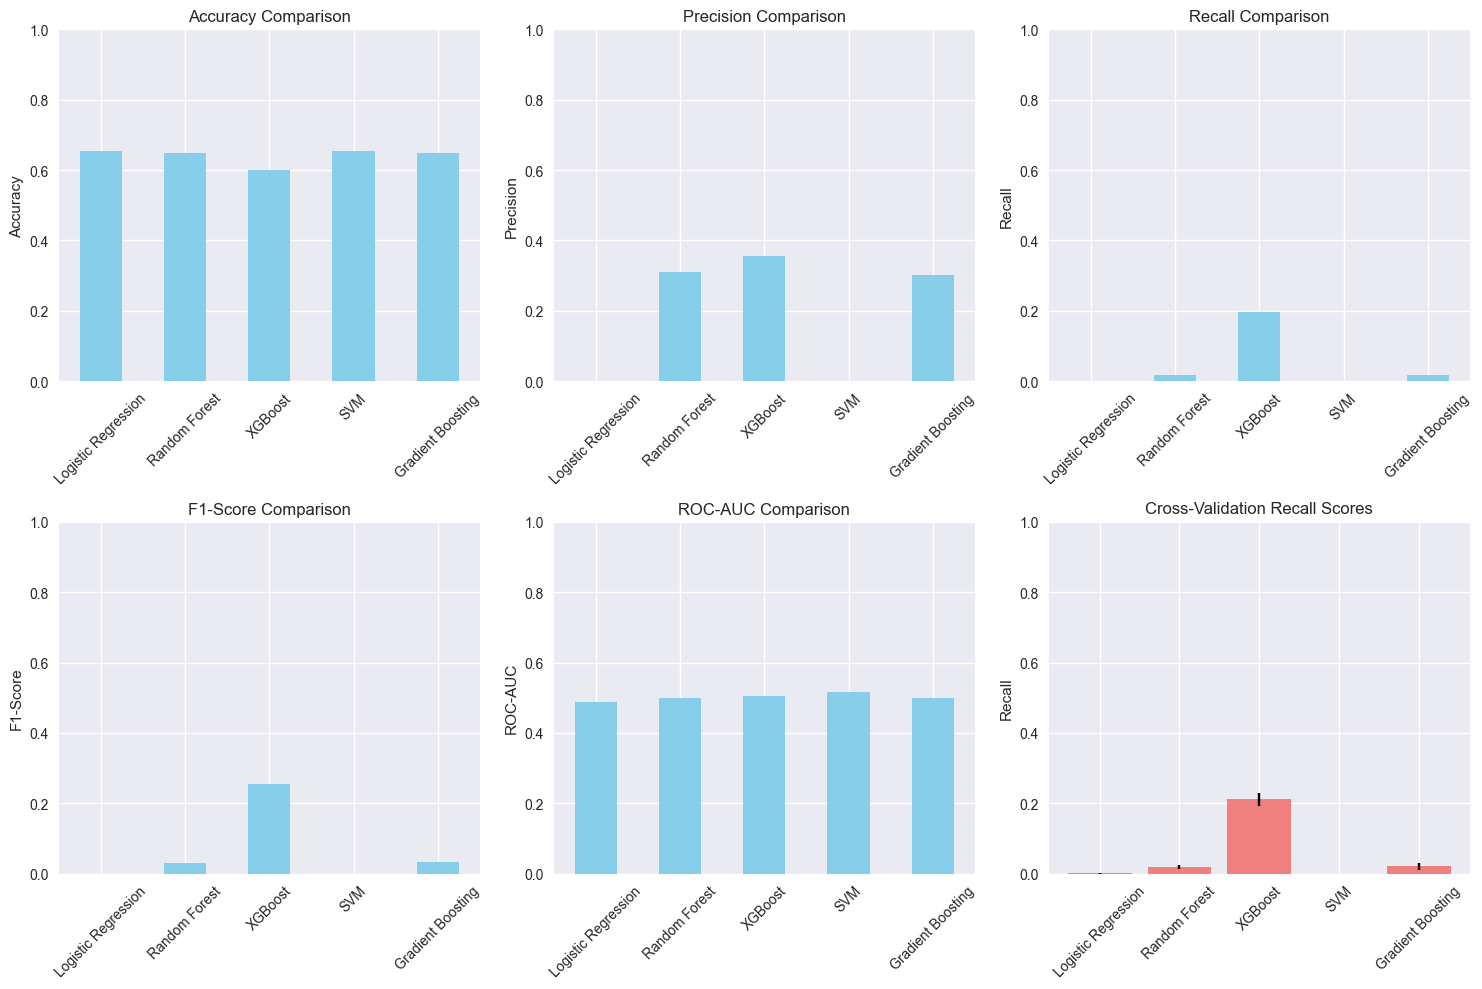


🏆 Best Model (highest Recall): XGBoost
   Recall Score: 0.1971


In [24]:
# Compare model performance
results_df = pd.DataFrame(results).T
results_df = results_df.drop('Model', axis=1)

print("\n" + "=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)
display(results_df.round(4))

# Visualize model comparison
plt.figure(figsize=(15, 10))

# Plot all metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    results_df[metric].plot(kind='bar', color='skyblue')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

# Cross-validation recall scores
plt.subplot(2, 3, 6)
cv_means = [cv_scores[model].mean() for model in cv_scores.keys()]
cv_stds = [cv_scores[model].std() for model in cv_scores.keys()]
plt.bar(range(len(cv_means)), cv_means, yerr=cv_stds, 
        capsize=5, color='lightcoral')
plt.title('Cross-Validation Recall Scores')
plt.ylabel('Recall')
plt.xticks(range(len(cv_scores)), list(cv_scores.keys()), rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Find best model based on recall (primary metric)
best_model_name = results_df['Recall'].idxmax()
best_model = results[best_model_name]['Model']

print(f"\n🏆 Best Model (highest Recall): {best_model_name}")
print(f"   Recall Score: {results_df.loc[best_model_name, 'Recall']:.4f}")

## 6. Hyperparameter Tuning

In [25]:
# Hyperparameter tuning for the best model
print(f"🔧 Performing hyperparameter tuning for {best_model_name}...")

# Define parameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'class_weight': [None, 'balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'scale_pos_weight': [1, 2]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Perform grid search
param_grid = param_grids.get(best_model_name, {})

if param_grid:
    # Create a fresh instance of the best model
    if best_model_name == 'Random Forest':
        model_for_tuning = RandomForestClassifier(random_state=42)
    elif best_model_name == 'XGBoost':
        model_for_tuning = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    elif best_model_name == 'Logistic Regression':
        model_for_tuning = LogisticRegression(random_state=42, max_iter=1000)
    elif best_model_name == 'Gradient Boosting':
        model_for_tuning = GradientBoostingClassifier(random_state=42)
    else:
        model_for_tuning = best_model
    
    # Select appropriate data for tuning
    if best_model_name in ['Logistic Regression', 'SVM']:
        X_tune = X_train_scaled
    else:
        X_tune = X_train
    
    # Grid search with focus on recall
    grid_search = GridSearchCV(
        estimator=model_for_tuning,
        param_grid=param_grid,
        scoring='recall',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_tune, y_train)
    
    print(f"✅ Best parameters found:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param}: {value}")
    
    print(f"✅ Best cross-validation recall score: {grid_search.best_score_:.4f}")
    
    # Update best model with tuned parameters
    best_model_tuned = grid_search.best_estimator_
    
else:
    print("No parameter grid defined for this model, using original best model")
    best_model_tuned = best_model

🔧 Performing hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
✅ Best parameters found:
   learning_rate: 0.01
   max_depth: 3
   n_estimators: 100
   scale_pos_weight: 2
   subsample: 1.0
✅ Best cross-validation recall score: 0.7609
✅ Best parameters found:
   learning_rate: 0.01
   max_depth: 3
   n_estimators: 100
   scale_pos_weight: 2
   subsample: 1.0
✅ Best cross-validation recall score: 0.7609


## 7. Model Evaluation and Performance Metrics

In [26]:
# Final model evaluation
print("🎯 FINAL MODEL EVALUATION")
print("=" * 60)

# Select appropriate validation data
if best_model_name in ['Logistic Regression', 'SVM']:
    X_val_final = X_val_scaled
else:
    X_val_final = X_val

# Make predictions with tuned model
y_val_pred = best_model_tuned.predict(X_val_final)
y_val_pred_proba = best_model_tuned.predict_proba(X_val_final)[:, 1]

# Calculate final metrics
final_accuracy = accuracy_score(y_val, y_val_pred)
final_precision = precision_score(y_val, y_val_pred)
final_recall = recall_score(y_val, y_val_pred)
final_f1 = f1_score(y_val, y_val_pred)
final_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# Store final metrics for submission
final_metrics = {
    'Model': best_model_name,
    'Accuracy': final_accuracy,
    'Precision': final_precision,
    'Recall': final_recall,
    'F1-Score': final_f1,
    'ROC-AUC': final_roc_auc
}

print(f"Model: {best_model_name}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC Score: {final_roc_auc:.4f}")

# Display classification report
print(f"\n📊 Detailed Classification Report:")
print(classification_report(y_val, y_val_pred, 
                          target_names=['No Risk', 'Risk']))

🎯 FINAL MODEL EVALUATION
Model: XGBoost
Accuracy: 0.4018
Precision: 0.3366
Recall: 0.7609
F1-Score: 0.4667
ROC-AUC Score: 0.4980

📊 Detailed Classification Report:
              precision    recall  f1-score   support

     No Risk       0.63      0.21      0.32      1045
        Risk       0.34      0.76      0.47       548

    accuracy                           0.40      1593
   macro avg       0.48      0.49      0.39      1593
weighted avg       0.53      0.40      0.37      1593



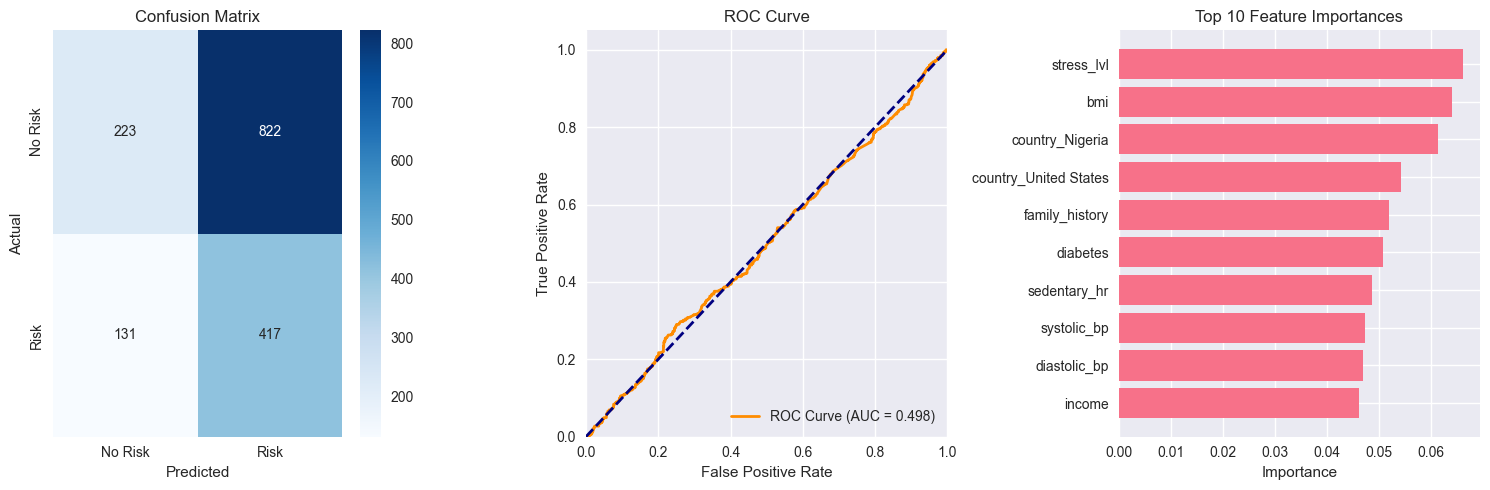

In [27]:
# Visualizations
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Risk', 'Risk'],
           yticklabels=['No Risk', 'Risk'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {final_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Feature Importance (if available)
plt.subplot(1, 3, 3)
if hasattr(best_model_tuned, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model_tuned.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
elif hasattr(best_model_tuned, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': abs(best_model_tuned.coef_[0])
    }).sort_values('importance', ascending=False).head(10)
    
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Top 10 Feature Coefficients (Absolute)')
    plt.xlabel('|Coefficient|')
    plt.gca().invert_yaxis()
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available\nfor this model', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')

plt.tight_layout()
plt.show()

## 8. Predictions on Test Data

In [28]:
# Make predictions on test data
print("🔮 Making predictions on test dataset...")

# Select appropriate test data
if best_model_name in ['Logistic Regression', 'SVM']:
    X_test_final = X_test_scaled
else:
    X_test_final = X_test

# Make predictions
test_predictions = best_model_tuned.predict(X_test_final)
test_predictions_proba = best_model_tuned.predict_proba(X_test_final)[:, 1]

print(f"✅ Predictions completed for {len(test_predictions)} patients")

# Analyze prediction distribution
unique, counts = np.unique(test_predictions, return_counts=True)
prediction_distribution = dict(zip(unique, counts))

print(f"\nPrediction Distribution:")
for risk_level, count in prediction_distribution.items():
    risk_label = "No Risk" if risk_level == 0 else "Risk"
    percentage = count / len(test_predictions) * 100
    print(f"  {risk_label} ({risk_level}): {count} patients ({percentage:.1f}%)")

# Show prediction probability statistics
print(f"\nPrediction Probability Statistics:")
print(f"  Mean probability: {test_predictions_proba.mean():.4f}")
print(f"  Std probability: {test_predictions_proba.std():.4f}")
print(f"  Min probability: {test_predictions_proba.min():.4f}")
print(f"  Max probability: {test_predictions_proba.max():.4f}")

🔮 Making predictions on test dataset...
✅ Predictions completed for 800 patients

Prediction Distribution:
  No Risk (0): 191 patients (23.9%)
  Risk (1): 609 patients (76.1%)

Prediction Probability Statistics:
  Mean probability: 0.5097
  Std probability: 0.0193
  Min probability: 0.3777
  Max probability: 0.5928


## 9. Save Results and Export Files

In [29]:
# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'patient_id': test_processed['patient_id'],
    'heart_attack_risk': test_predictions
})

# Display sample predictions
print("📄 Sample Predictions:")
display(predictions_df.head(10))

# Save predictions to CSV with team information
predictions_filename = 'EM21_BitSync_Task1_Predictions.csv'
predictions_df.to_csv(predictions_filename, index=False)
print(f"✅ Predictions saved to: {predictions_filename}")

# Verify the CSV format
print(f"\n📋 CSV File Verification:")
print(f"  File name: {predictions_filename}")
print(f"  Shape: {predictions_df.shape}")
print(f"  Columns: {list(predictions_df.columns)}")
print(f"  First 3 rows:")
print(predictions_df.head(3).to_string(index=False))

📄 Sample Predictions:


,patient_id,heart_attack_risk
0,VRK5064,1
1,NEN2365,0
2,KXT2493,1
3,TKO0406,1
4,GDP2405,1
5,GRQ8132,1
6,KUL5067,1
7,OTZ1268,0
8,EZN4283,0
9,HVE8034,1


✅ Predictions saved to: EM21_BitSync_Task1_Predictions.csv

📋 CSV File Verification:
  File name: EM21_BitSync_Task1_Predictions.csv
  Shape: (800, 2)
  Columns: ['patient_id', 'heart_attack_risk']
  First 3 rows:
patient_id  heart_attack_risk
   VRK5064                  1
   NEN2365                  0
   KXT2493                  1


🏆 FINAL TRAINING METRICS FOR SUBMISSION
Model: XGBoost
Accuracy: 0.4018
Precision: 0.3366
Recall: 0.7609
F1-Score: 0.4667
ROC-AUC Score: 0.4980


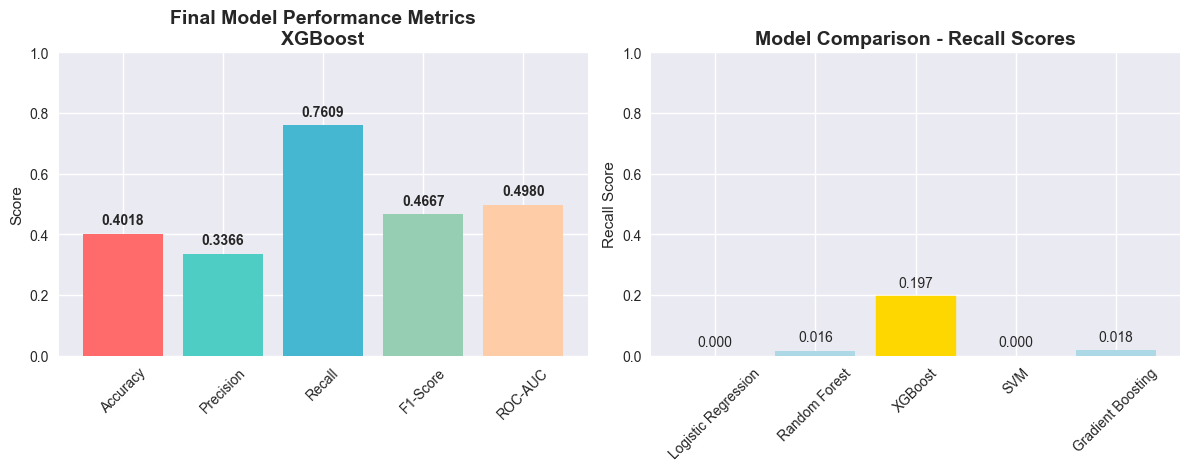

✅ Metrics screenshot saved as: EM21_BitSync_Task1_Metrics.png

📋 SUBMISSION SUMMARY - Team EM21 BitSync
✅ Notebook: EM21_BitSync_Task1_HeartAttack.ipynb
✅ Predictions: EM21_BitSync_Task1_Predictions.csv
✅ Metrics Screenshot: EM21_BitSync_Task1_Metrics.png

🎯 Primary Metric (Recall): 0.7609
🤖 Best Model: XGBoost
📊 Total Predictions: 800
👥 Team: EM21 - BitSync


In [30]:
# Display final metrics for screenshot
print("🏆 FINAL TRAINING METRICS FOR SUBMISSION")
print("=" * 50)
print(f"Model: {final_metrics['Model']}")
print(f"Accuracy: {final_metrics['Accuracy']:.4f}")
print(f"Precision: {final_metrics['Precision']:.4f}")
print(f"Recall: {final_metrics['Recall']:.4f}")
print(f"F1-Score: {final_metrics['F1-Score']:.4f}")
print(f"ROC-AUC Score: {final_metrics['ROC-AUC']:.4f}")
print("=" * 50)

# Create a visual display of metrics for screenshot
plt.figure(figsize=(12, 8))

# Metrics visualization
plt.subplot(2, 2, 1)
metrics_names = list(final_metrics.keys())[1:]  # Skip 'Model'
metrics_values = [final_metrics[key] for key in metrics_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECCA7']

bars = plt.bar(metrics_names, metrics_values, color=colors)
plt.title(f'Final Model Performance Metrics\n{best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45)

# Model comparison (recall focus)
plt.subplot(2, 2, 2)
recall_scores = [results[model]['Recall'] for model in results.keys()]
model_names = list(results.keys())
bars = plt.bar(model_names, recall_scores, color='lightblue')
plt.title('Model Comparison - Recall Scores', fontsize=14, fontweight='bold')
plt.ylabel('Recall Score')
plt.ylim(0, 1)
for bar, score in zip(bars, recall_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.3f}', ha='center', va='bottom')
plt.xticks(rotation=45)

# Highlight best model
best_idx = model_names.index(best_model_name)
bars[best_idx].set_color('gold')

plt.tight_layout()
plt.savefig('EM21_BitSync_Task1_Metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Metrics screenshot saved as: EM21_BitSync_Task1_Metrics.png")

# Summary
print(f"\n📋 SUBMISSION SUMMARY - Team EM21 BitSync")
print("=" * 50)
print(f"✅ Notebook: EM21_BitSync_Task1_HeartAttack.ipynb")
print(f"✅ Predictions: {predictions_filename}")
print(f"✅ Metrics Screenshot: EM21_BitSync_Task1_Metrics.png")
print(f"\n🎯 Primary Metric (Recall): {final_metrics['Recall']:.4f}")
print(f"🤖 Best Model: {best_model_name}")
print(f"📊 Total Predictions: {len(predictions_df)}")
print(f"👥 Team: EM21 - BitSync")
print("=" * 50)